In [493]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import pandas as pd

In [494]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [495]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

1.10.0
11.3
True
1
0


In [ ]:
method = ''
from g2g_model_Fisher import *

In [529]:
data_path = 'data/'
data_name = 'DG_bin'
adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
[k_nei, K, L] = [10, 4, 10]
result_path = 'results/'+data_name+','+method+','+str([k_nei,K,L])+'/'

In [532]:
#-------data preprocessing
adata=adata0.copy()
scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [530]:
gene_arr=adata.var.index.values
X_pca=adata.obsm['X_pca']
X_umap=adata.obsm['X_umap']
cell_vpt=adata.obs['velocity_pseudotime'].values#adata0.obs['latent_time'].values#
Xs=adata.layers['Ms']#adata.X.A#
X_pca.shape

(3184, 50)

In [531]:
# plt.scatter(X_pca[:,0],X_pca[:,1],s=10,c=cell_vpt,cmap=plt.cm.jet)
# plt.xlabel('PC1',fontsize=14)
# plt.ylabel('PC2',fontsize=14)
# clb=plt.colorbar()


# clb.ax.set_ylabel('pseudotime',fontsize=14)

# plt.savefig(result_path+'EG_vpt.png',dpi=600)
# plt.show()

# plt.scatter(X_umap[:,0],X_umap[:,1],s=10,c=cell_vpt,cmap=plt.cm.jet)
# plt.show()

In [533]:
row =np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()

col=adata.uns['neighbors']['indices'].flatten()

w_val=np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])

adj_val=np.ones(col.shape)

A_mat=csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

W_mat=csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

In [534]:
#--------calculate neighbor distance and define smooth funciton with gaussian kernel
#-----check "Study on density peaks clustering based on k-nearest neighbors and principal component analysis
#--------Mingjing Du et al 2016

# dc=np.amax(w_val)

# cell_nei=adata.uns['neighbors']['indices']
# nei_w=[]
# rho_arr=[]
# for i in range(cell_nei.shape[0]):
#     dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
#     rho=np.sum(np.exp(-dij**2/dc**2))
#     nei_w.append(np.exp(-dij**2/dc**2)/rho)
#     rho_arr.append(rho)
# rho_arr=np.array(rho_arr)/np.amax(rho_arr)
# nei_w=np.array(nei_w)

In [535]:
dc=np.mean(w_val)

cell_nei=adata.uns['neighbors']['indices']
nei_w=[]
rho_arr=[]
for ni in adata.uns['neighbors']['indices']:
    dij=np.array([np.linalg.norm(X_pca[int(ni[0]),:]-X_pca[int(i),:]) for i in ni[1:]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2


# plt.scatter(X_pca[:,0],X_pca[:,1],s=5,c=rho_arr,cmap=plt.cm.jet)
# plt.colorbar()
# plt.show()

In [536]:
np.save(result_path+'cell_nei',cell_nei)
np.save(result_path+'nei_w',nei_w)

In [537]:
def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

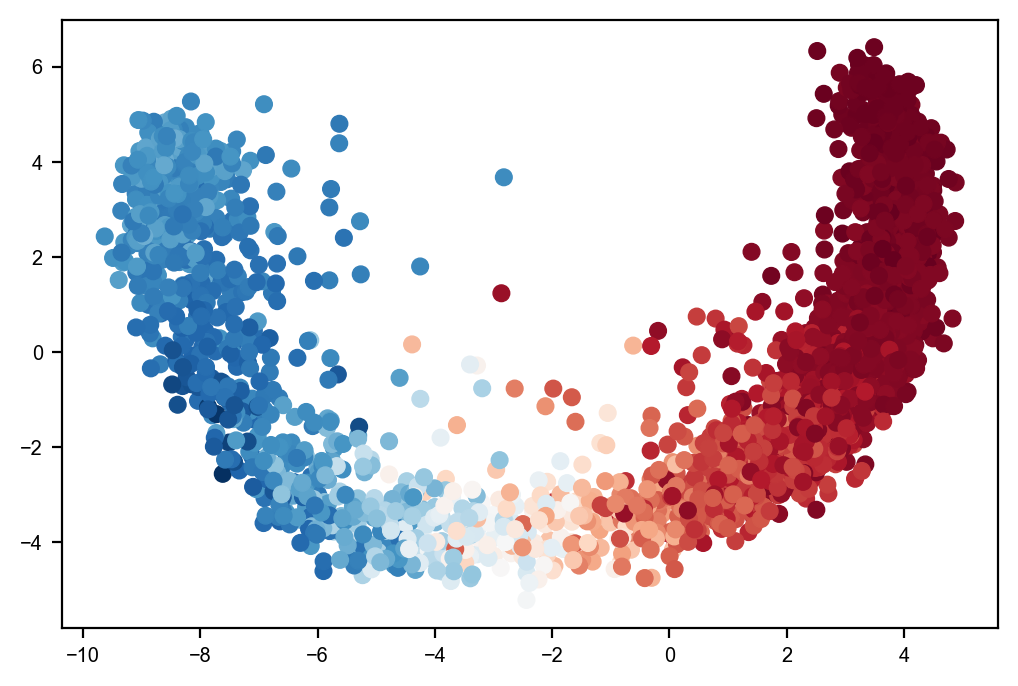

In [538]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=cell_vpt)

In [539]:
epochs = 200
nsamples = 5
learning_rate = 1e-3
seed = 0
# n_workers = 4

if seed is not None:
    reset_seeds(seed)

A=A_mat
X=Xs
# X=Xs/np.mean(np.abs(Xs),axis=0)
# X=adata.X.A
#--------do not normalize X
# scaler=StandardScaler()#
# X=scaler.fit_transform(X0_ori)
z=cell_vpt

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

encoder = Encoder(X.shape[1], L)
# encoder = torch.load(result_path+'encoder.pt')

In [540]:
nei_num = np.array([Xs.shape[0]-len(train_data.level_sets[i][-1]) for i in range(Xs.shape[0])])
nei_ratio = nei_num/Xs.shape[0]
ave_num = np.mean(nei_num)
std_num = np.std(nei_num)
max_num = np.max(nei_num)
ave_ratio = ave_num/Xs.shape[0]
std_ratio = std_num/Xs.shape[0]
max_ratio = max_num/Xs.shape[0]
print([ave_num,std_num,max_num,ave_ratio,std_ratio,max_ratio])

np.save(result_path+'nei_num',nei_num)
np.save(result_path+'nei_stat',[ave_num,std_num,max_num,ave_ratio,std_ratio,max_ratio])

[329.8910175879397, 134.59378581726128, 995, 0.10360898793591071, 0.04227191765617502, 0.3125]


In [541]:
# nei_num = np.load(result_path+'nei_num.npy')
# nei_stat = np.load(result_path+'nei_stat.npy')

In [542]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs #// n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
#     num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [543]:
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

0 tensor(3.3225e+11, grad_fn=<DivBackward0>)
10 tensor(2.5704e+09, grad_fn=<DivBackward0>)
20 tensor(2.1321e+09, grad_fn=<DivBackward0>)
30 tensor(1.9654e+09, grad_fn=<DivBackward0>)
40 tensor(1.8467e+09, grad_fn=<DivBackward0>)
50 tensor(1.7976e+09, grad_fn=<DivBackward0>)
60 tensor(1.7635e+09, grad_fn=<DivBackward0>)
70 tensor(1.7421e+09, grad_fn=<DivBackward0>)
80 tensor(1.7292e+09, grad_fn=<DivBackward0>)
90 tensor(1.7128e+09, grad_fn=<DivBackward0>)
100 tensor(1.6933e+09, grad_fn=<DivBackward0>)
110 tensor(1.7001e+09, grad_fn=<DivBackward0>)
120 tensor(1.6815e+09, grad_fn=<DivBackward0>)
130 tensor(1.6845e+09, grad_fn=<DivBackward0>)
140 tensor(1.6710e+09, grad_fn=<DivBackward0>)
150 tensor(1.6651e+09, grad_fn=<DivBackward0>)
160 tensor(1.6595e+09, grad_fn=<DivBackward0>)
170 tensor(1.6656e+09, grad_fn=<DivBackward0>)
180 tensor(1.6653e+09, grad_fn=<DivBackward0>)
190 tensor(1.6559e+09, grad_fn=<DivBackward0>)


In [544]:
torch.save(encoder,result_path+'encoder.pt')

In [545]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

In [546]:
# plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=X_label,cmap=plt.cm.jet)
# plt.show()


# plt.scatter(X_sigma[:,0],X_sigma[:,1],s=10,c=X_label,cmap=plt.cm.jet)
# plt.show()

# fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(111, projection="3d")
# fig.add_axes(ax)
# ax.scatter(
#     X_mu[:, 0],X_mu[:, 1], X_mu[:, 2], c=X_label, s=10, alpha=0.8,cmap=plt.cm.jet
# )

# ax.set_xlabel("$\mu_1$",fontsize=16)
# ax.set_ylabel("$\mu_2$",fontsize=16)
# ax.set_zlabel("$\mu_3$",fontsize=16)
# plt.savefig(result_path+'DG_Xmu_vpt.png')
# plt.show()

# fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(111, projection="3d")
# fig.add_axes(ax)
# ax.scatter(
#     X_sigma[:, 0],X_sigma[:, 1], X_sigma[:, 2], c=X_label, s=10, alpha=0.8,cmap=plt.cm.jet
# )

# ax.set_xlabel("$\sigma_1$",fontsize=16)
# ax.set_ylabel("$\sigma_2$",fontsize=16)
# ax.set_zlabel("$\sigma_3$",fontsize=16)
# ax.view_init(elev=10, azim=65, roll=-25)
# plt.savefig(result_path+'DG_Xsigma_vpt.png')
# plt.show()

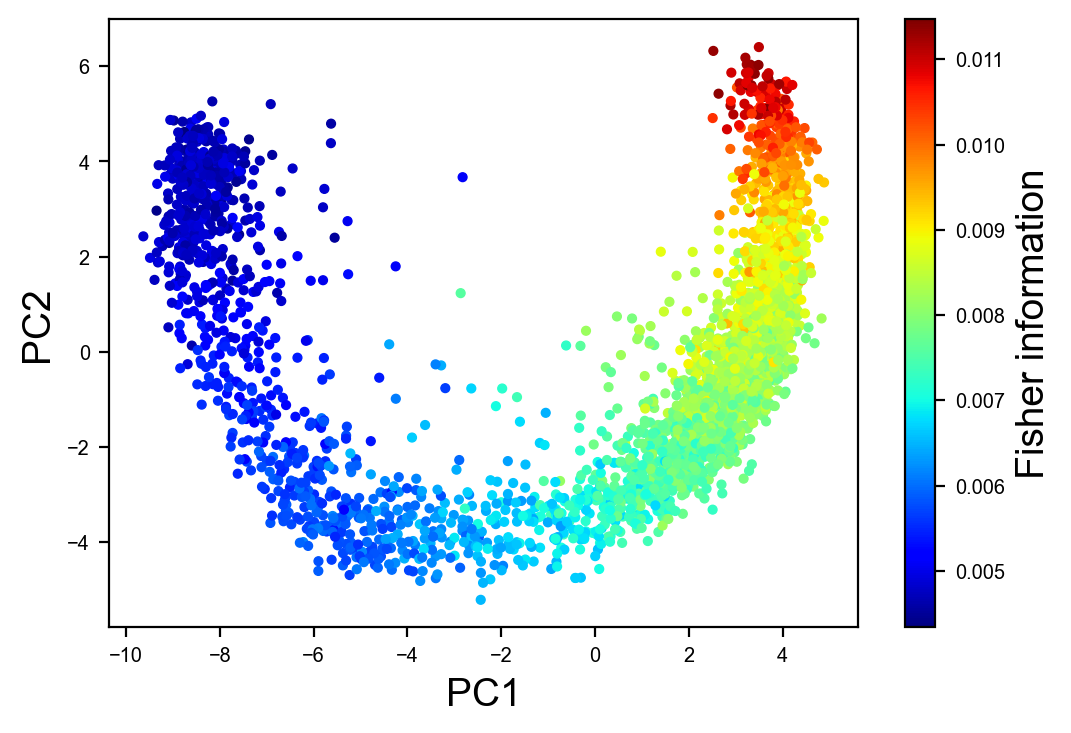

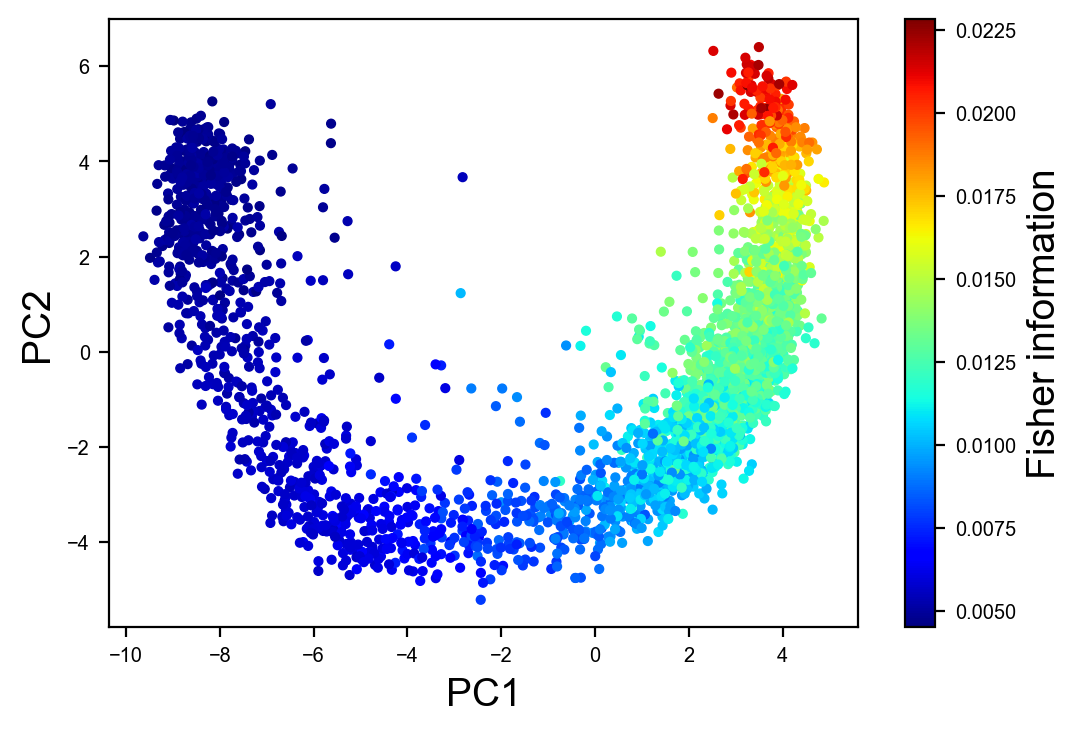

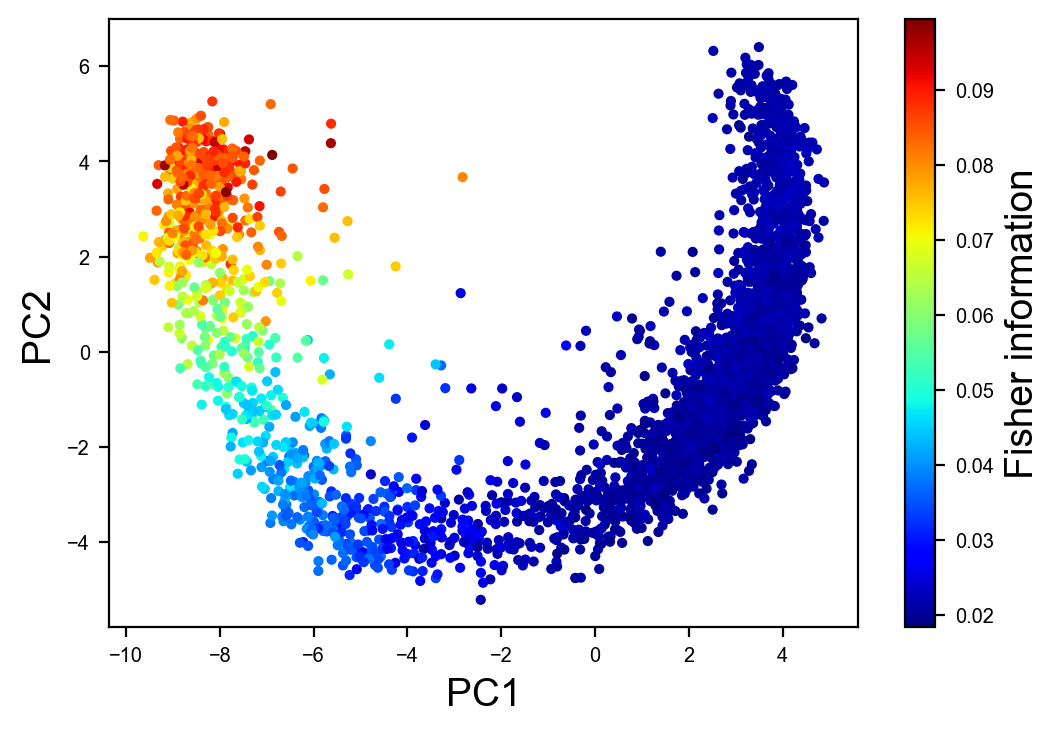

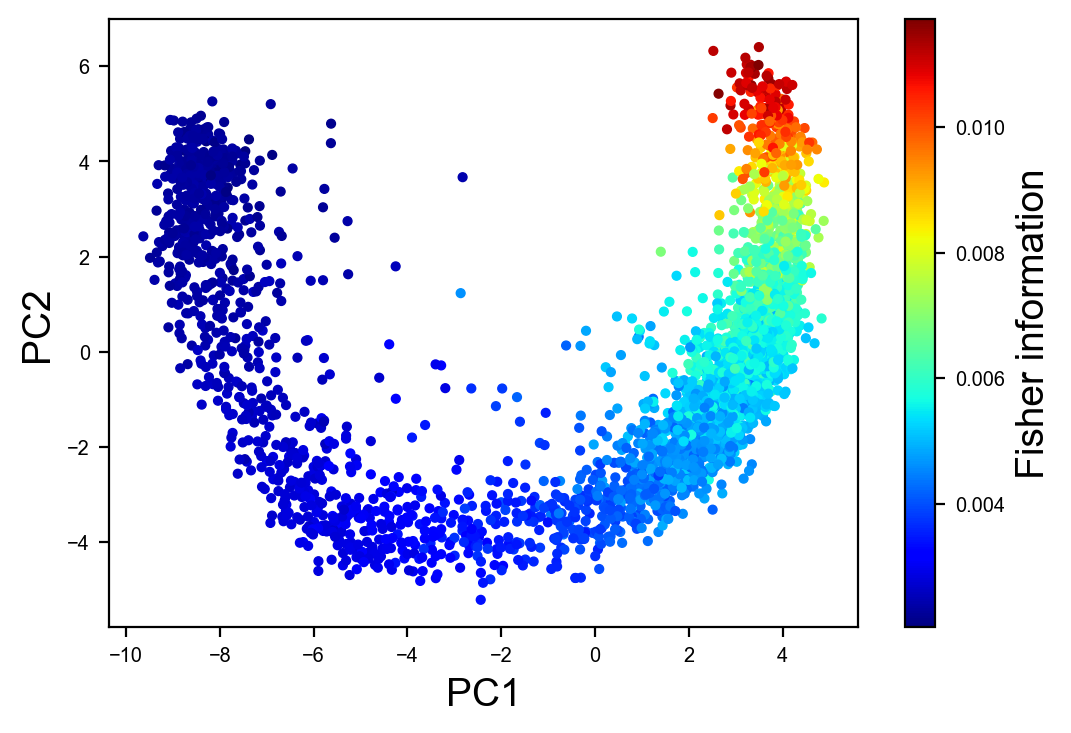

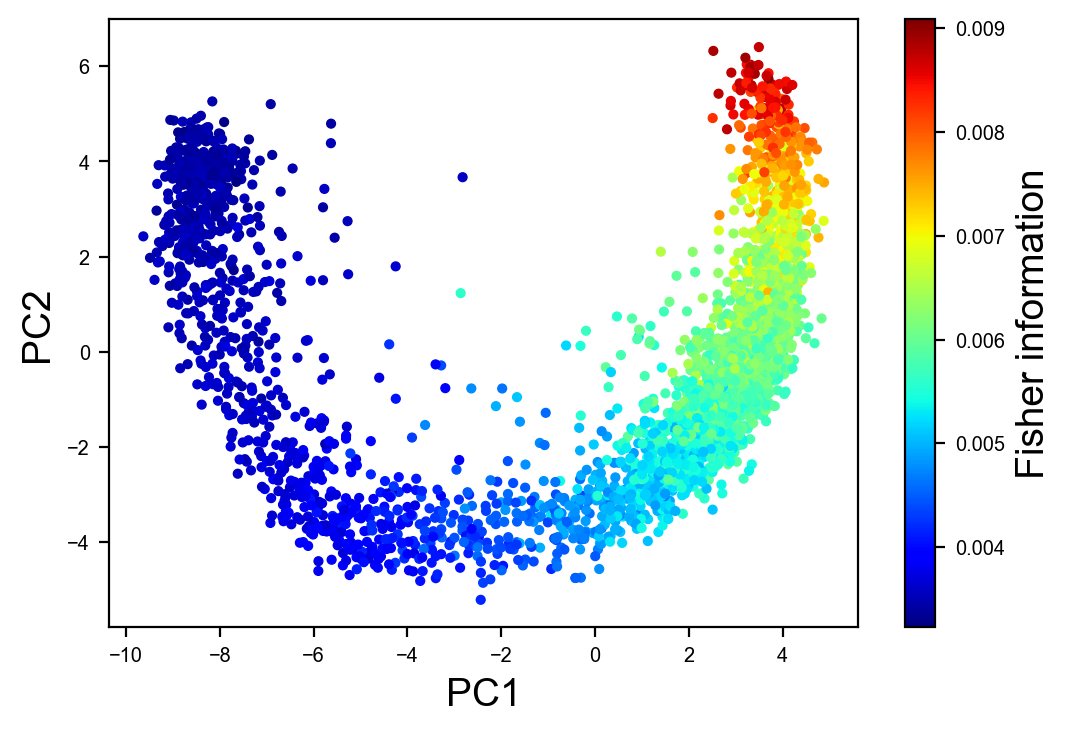

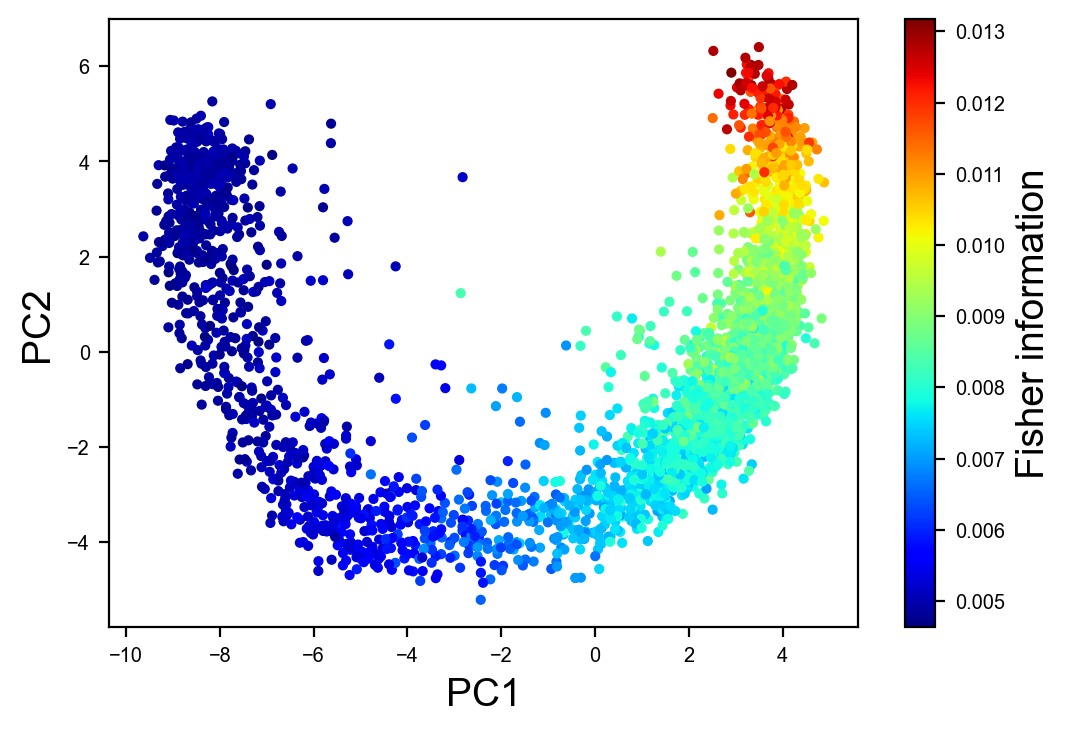

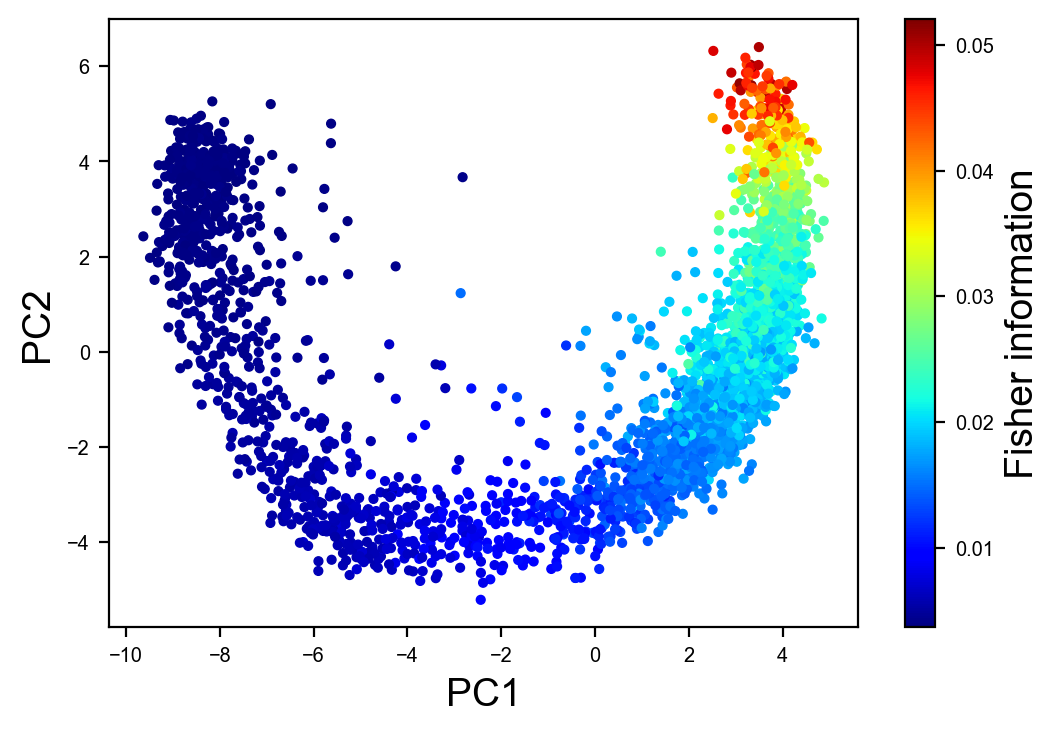

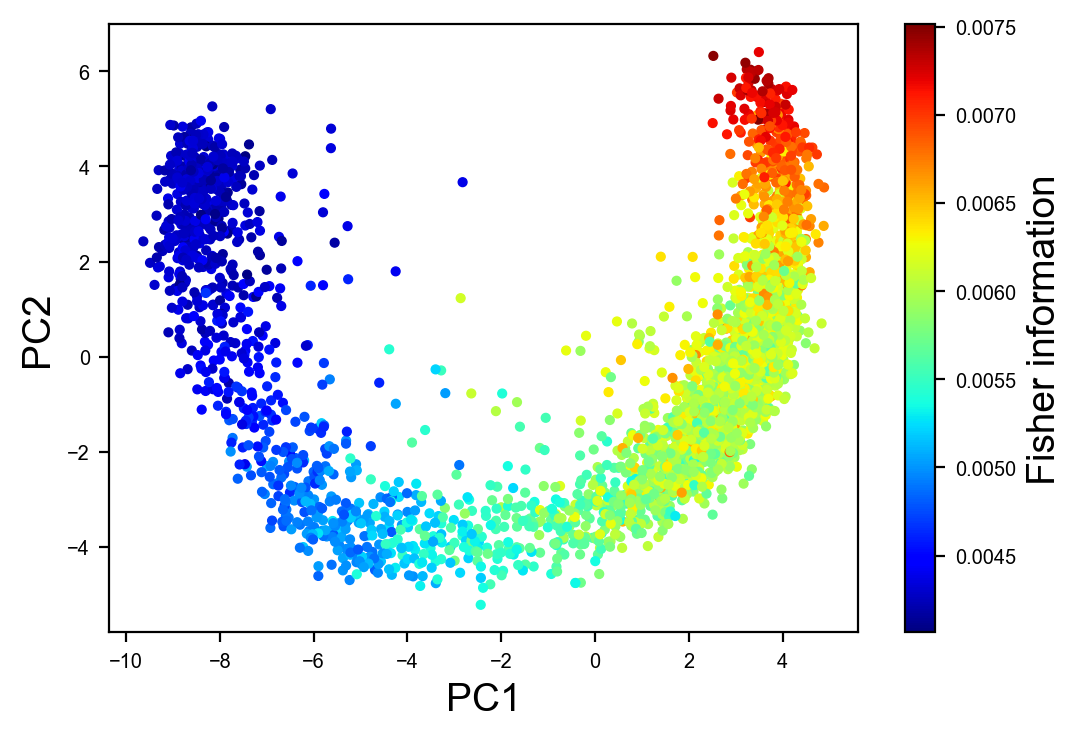

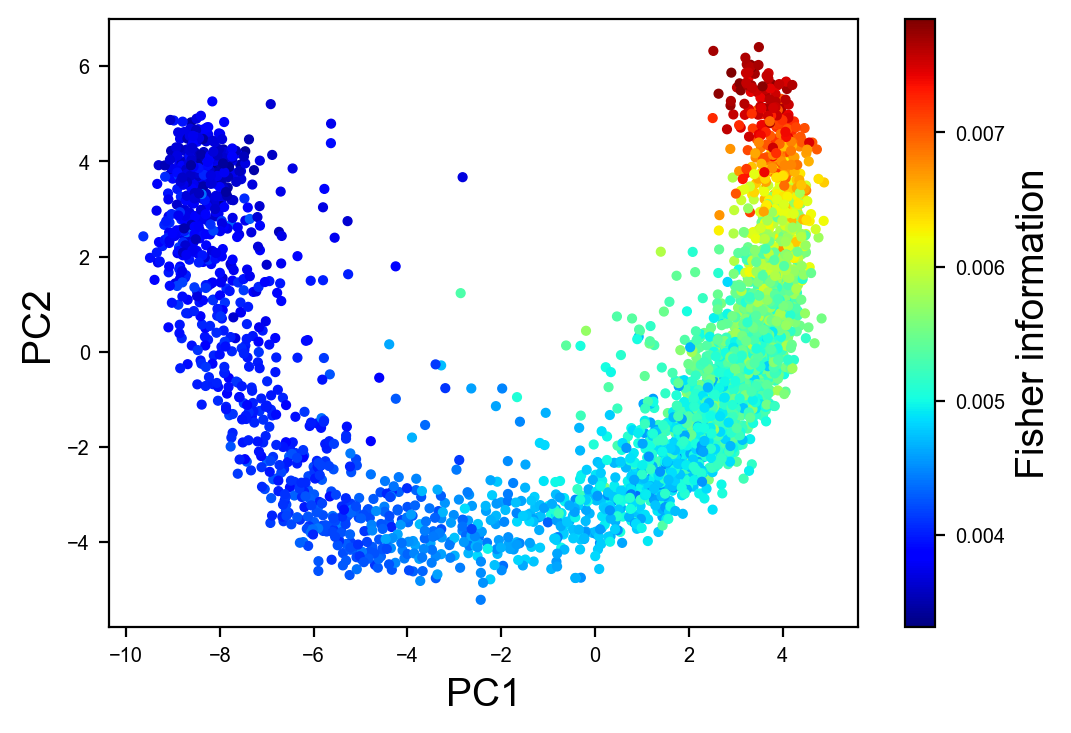

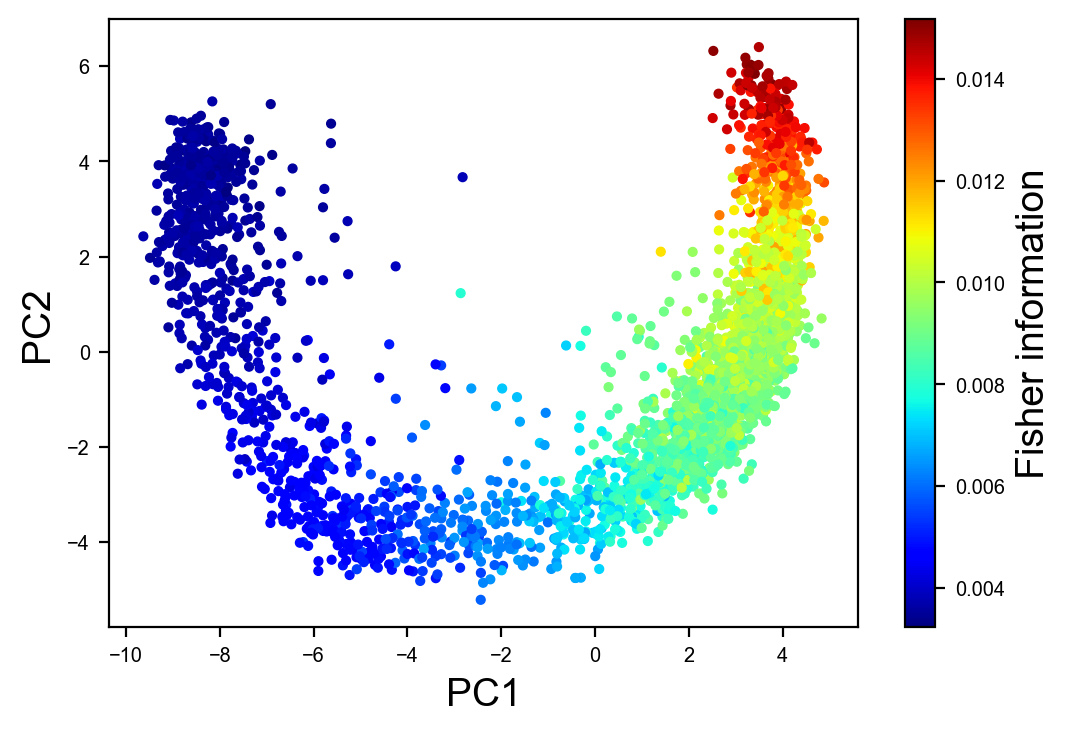

In [547]:
for i in range(L):
    plt.scatter(X_pca[:,0],X_pca[:,1],s=10,c=Fisher_g[:,i,i],cmap=plt.cm.jet)
    plt.xlabel('PC1',fontsize=14)
    plt.ylabel('PC2',fontsize=14)
    
    clb=plt.colorbar()
    clb.ax.set_ylabel('Fisher information',fontsize=14)
    plt.savefig(result_path+'g_'+str(i)+'.png')
    plt.show()

In [548]:
cRc_arr=[]
cRc_arr_eu=[]

for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

In [549]:
np.save(result_path+'crc',crc)
np.save(result_path+'crc_eu',crc_eu)
np.save(result_path+'crc_smooth',crc_smooth)

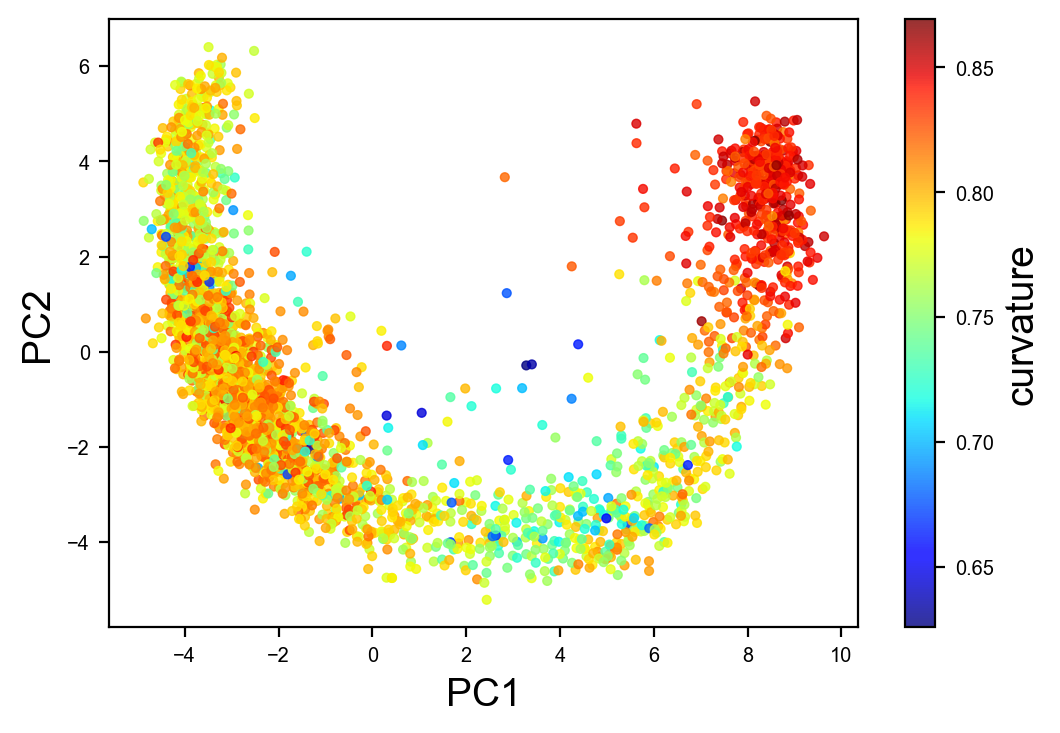

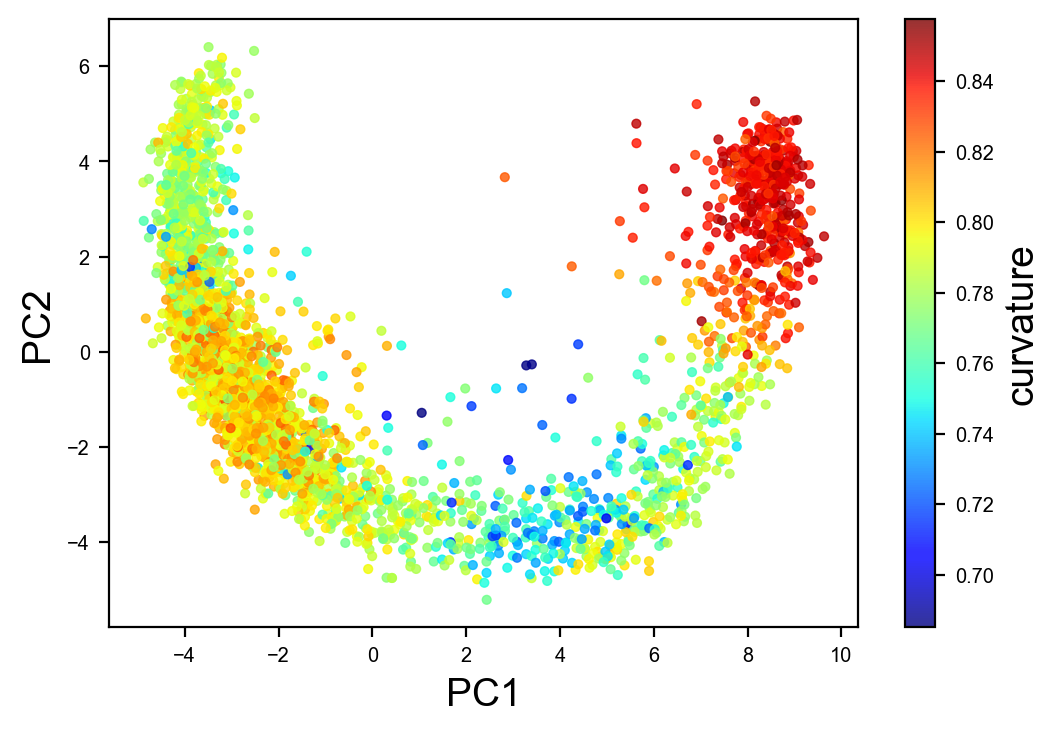

In [550]:
plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1], c=crc_eu, s=10, alpha=0.8,cmap=plt.cm.jet)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=14)
plt.savefig(result_path+'cv.png')
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1], c=crc_smooth, s=10, alpha=0.8,cmap=plt.cm.jet)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=14)
plt.savefig(result_path+'cv_smooth.png')
plt.show()

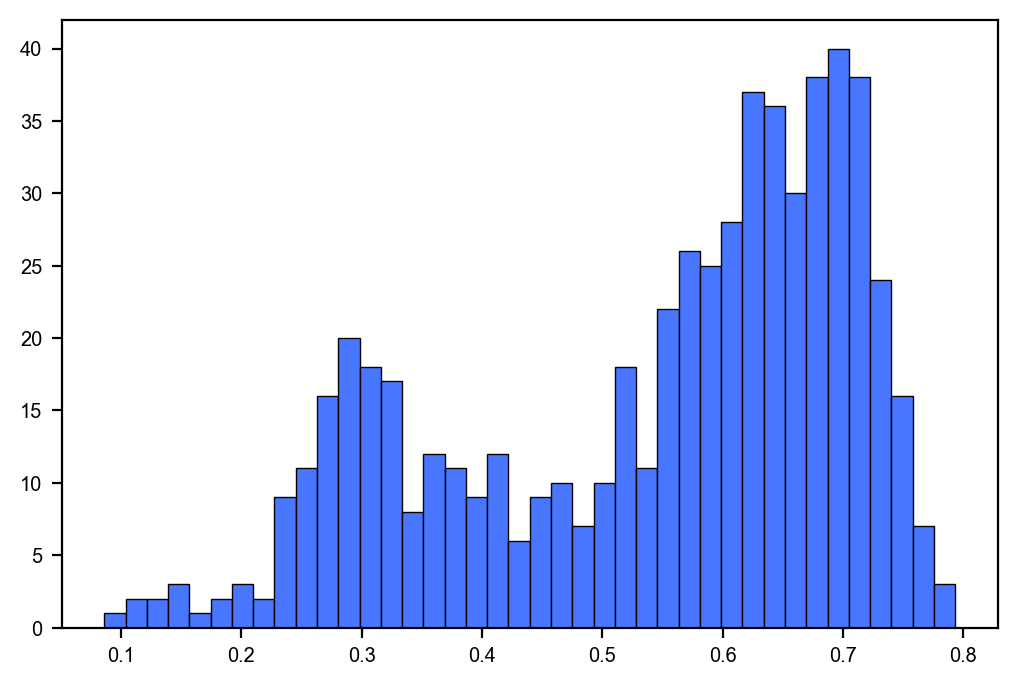

In [551]:
cRc_gene_corr=[]
for gi in range(Xs.shape[1]):
#     print(np.corrcoef(Xs[:,gi],cRc_arr))
    cRc_gene_corr.append(np.corrcoef(Xs[:,gi],cRc_arr)[0,1])
plt.hist(np.abs(cRc_gene_corr),bins=40,edgecolor='k')
plt.show()

In [552]:
cRc_keygene=gene_arr[np.abs(cRc_gene_corr)>0.9]
print(cRc_keygene)

for kg in cRc_keygene:
    scv.pl.scatter(adata, basis='pca', color=kg,colorbar=True)

[]


In [553]:
velo = np.array(adata.layers['velocity'])
# pca_dim=20
# velo = adata.obsm['velocity_pca'][:,:pca_dim]

In [554]:
pMu_pX = np.zeros([X.shape[0],L,X.shape[1]])
pSgm_pX = np.zeros([X.shape[0],L,X.shape[1]])
for i in range(X.shape[0]):
    pMu_pX[i],pSgm_pX[i] = Jacobian_nn(X[i],L,encoder)

mu_velo = np.array([pMu_pX[i]@velo[i] for i in range(X.shape[0])])
sgm_velo = np.array([pSgm_pX[i]@velo[i] for i in range(X.shape[0])])
zv2 = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    for j in range(L):
        zv2[i] += Fisher_g[i,j,j]*mu_velo[i,j]**2 + Fisher_g[i,L+j,L+j]*sgm_velo[i,j]**2
zv1 = np.sqrt(zv2)
zv1_smooth = smooth_func(zv1)

In [555]:
np.save(result_path+'pMu_pX',pMu_pX)
np.save(result_path+'pSgm_pX',pSgm_pX)

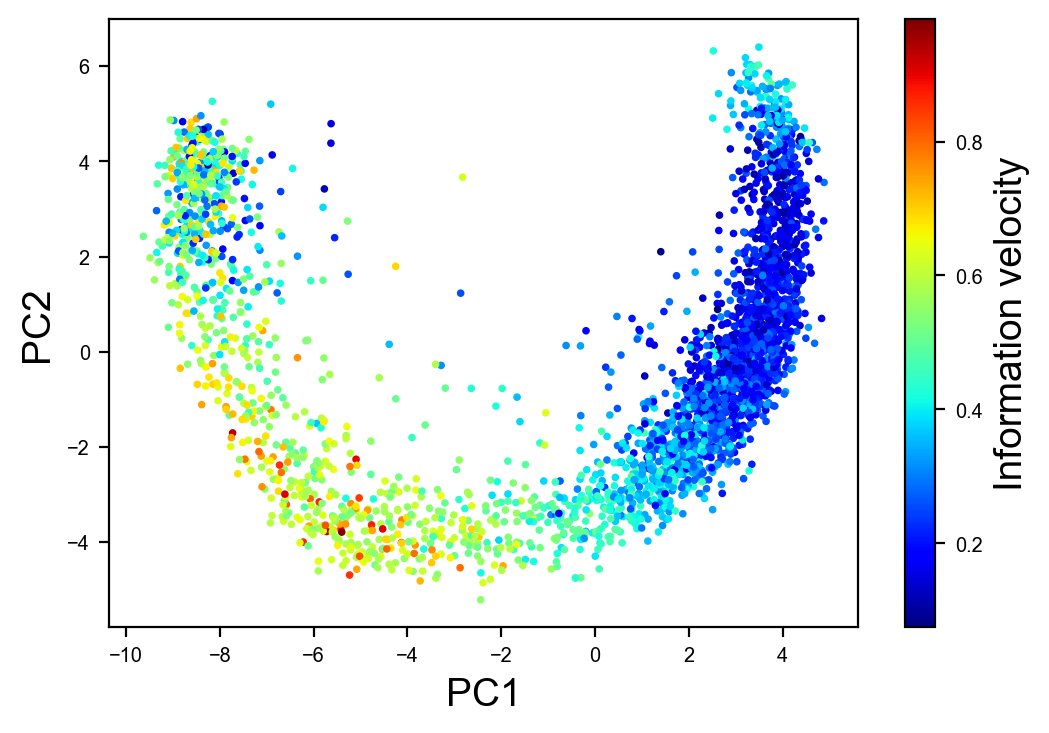

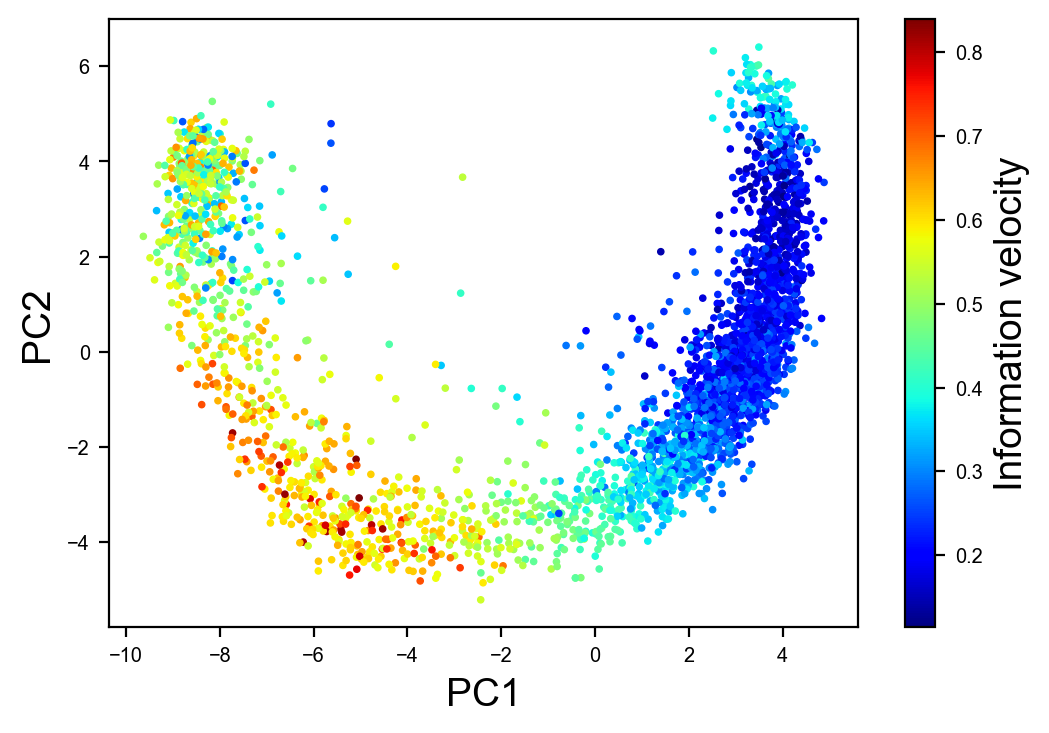

In [556]:
plt.scatter(-1*adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=zv1,cmap=plt.cm.jet)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
clb=plt.colorbar()
clb.ax.set_ylabel('Information velocity',fontsize=14)
plt.savefig(result_path+'iv.png')
plt.show()

plt.scatter(-1*adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=zv1_smooth,cmap=plt.cm.jet)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
clb=plt.colorbar()
clb.ax.set_ylabel('Information velocity',fontsize=14)
plt.savefig(result_path+'iv_smooth.png')
plt.show()

# plt.scatter(X_sigma[:,0],X_sigma[:,1], c=zv1, s=2, alpha=0.8,cmap=plt.cm.jet)
# plt.colorbar()
# plt.show()

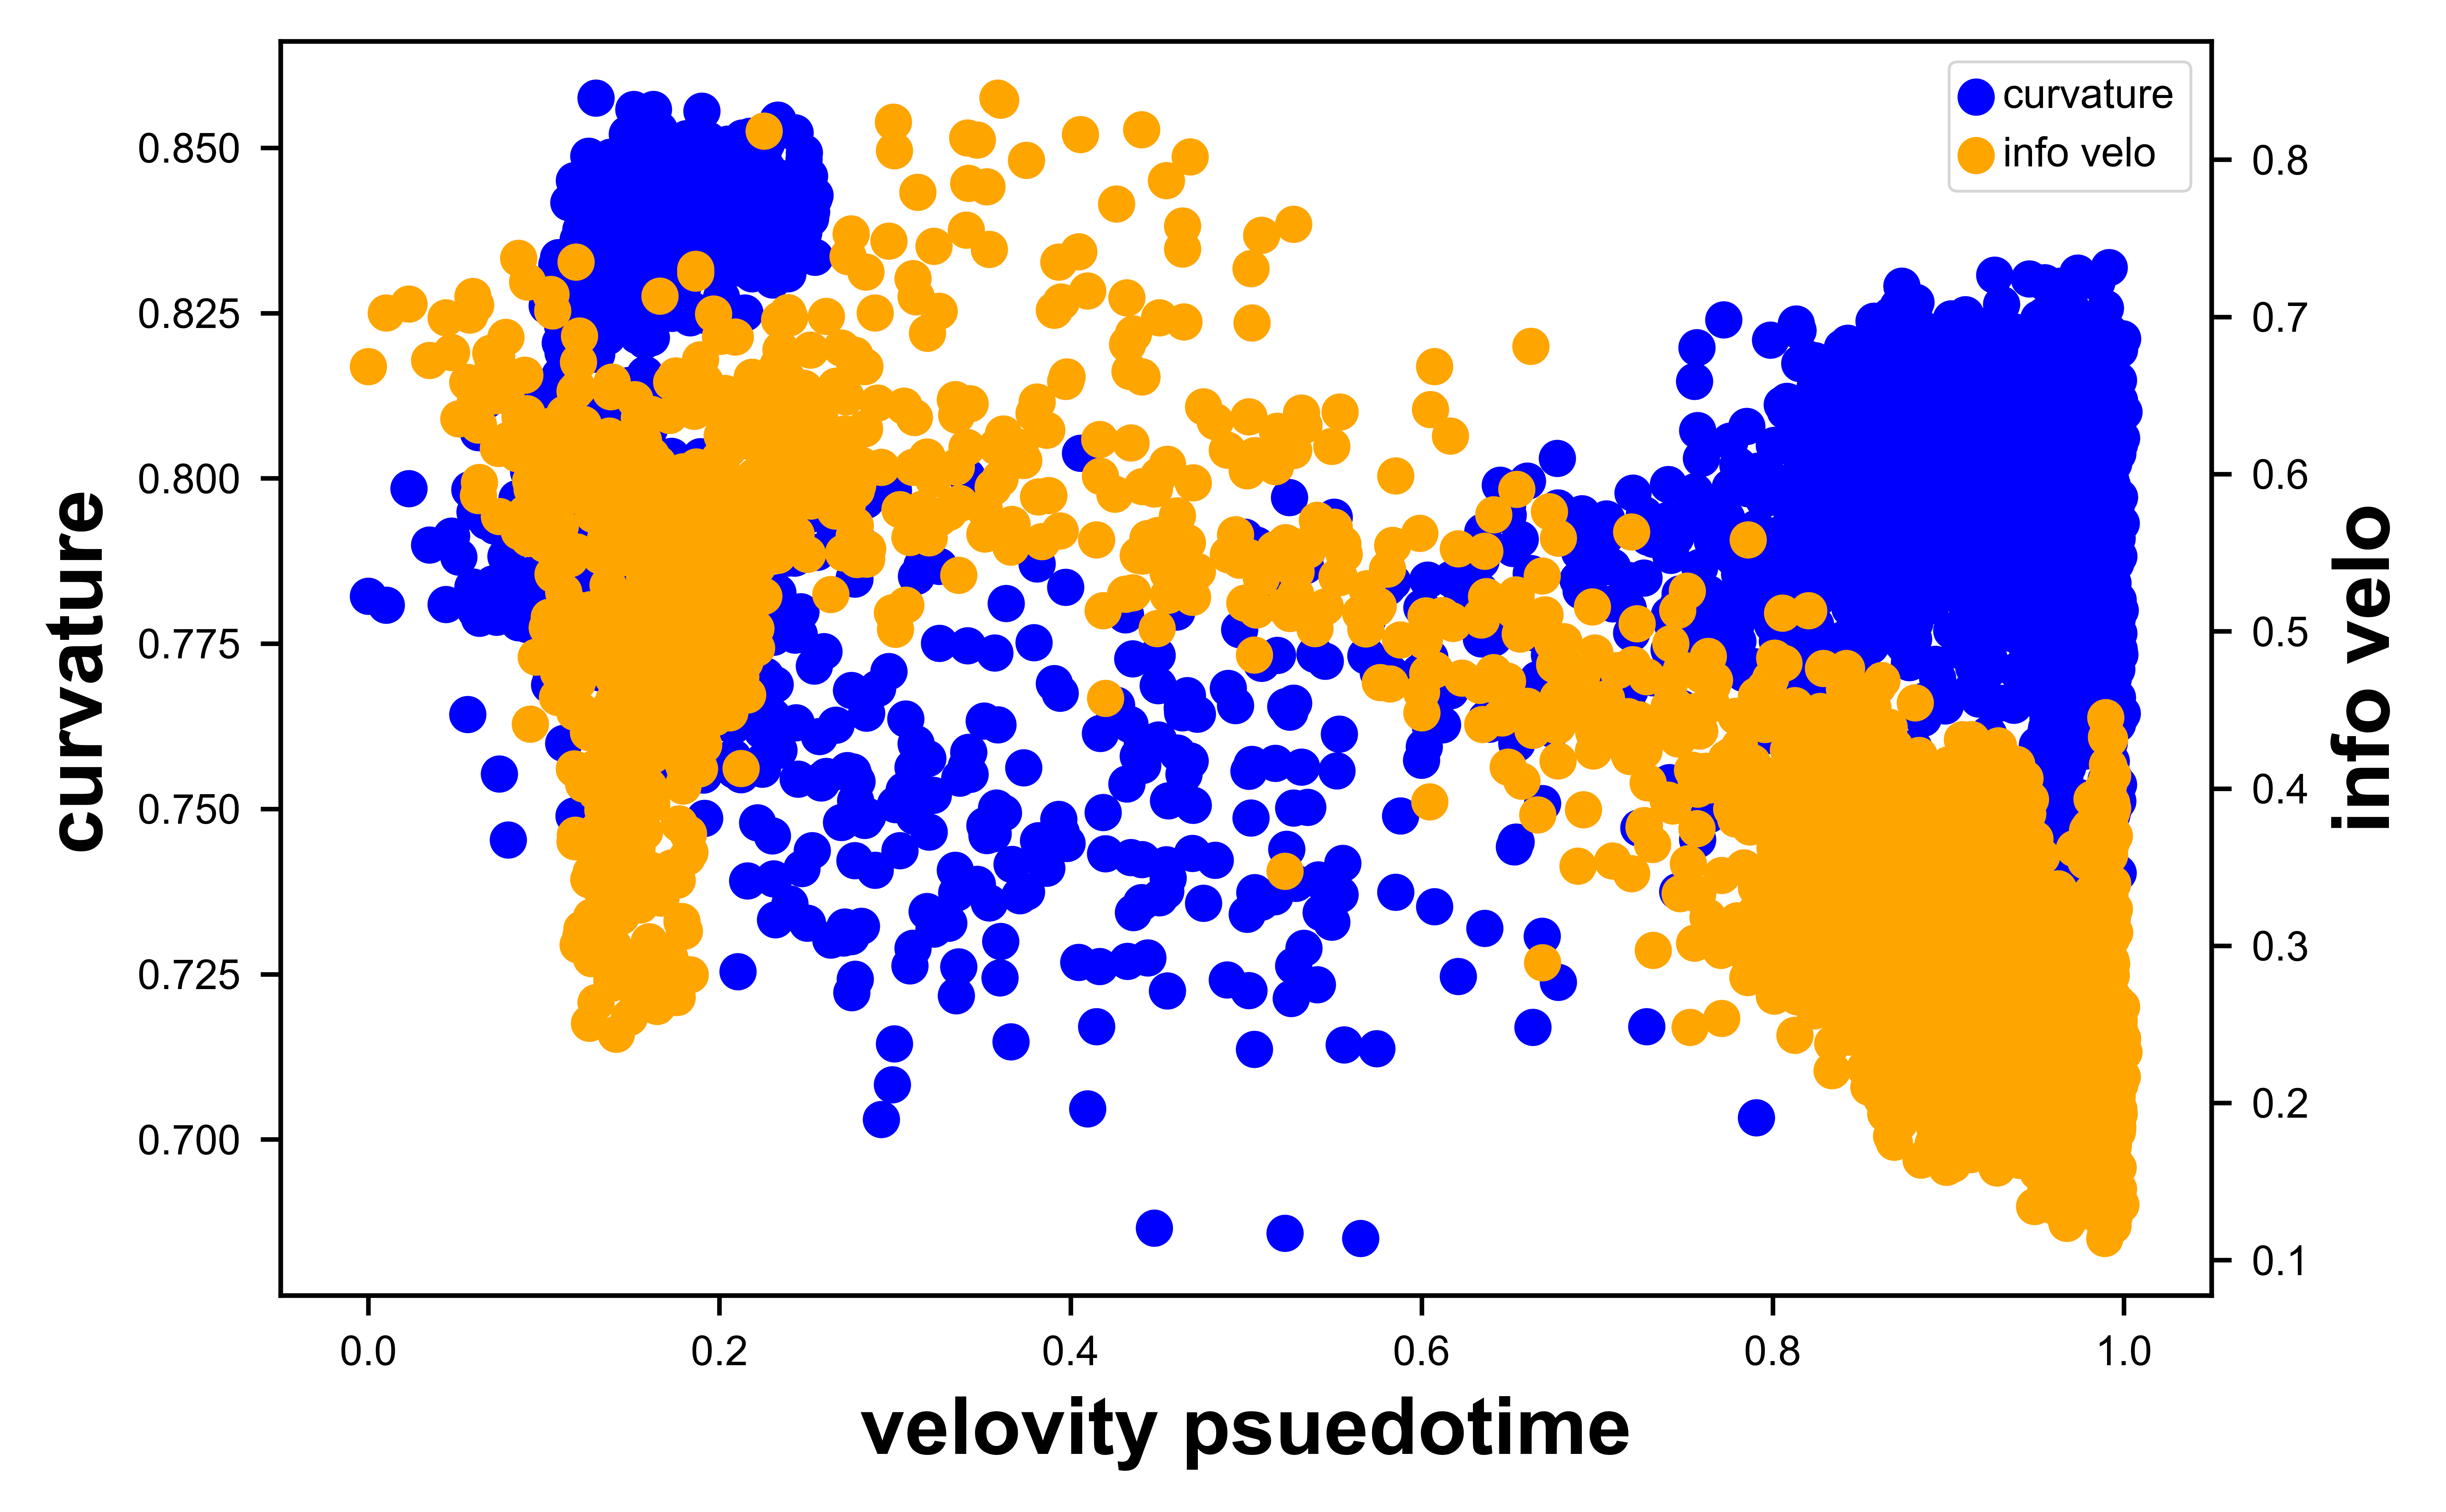

In [557]:
plt.figure(dpi=600)
ln1 = plt.scatter(cell_vpt,crc_smooth,c='blue',label='curvature')
plt.xlabel('velovity psuedotime',fontsize=14,weight='bold')
plt.ylabel('curvature',fontsize=14,weight='bold')
plt.twinx()
ln2 = plt.scatter(cell_vpt,zv1_smooth,c='orange',label='info velo')
plt.ylabel('info velo',fontsize=14,weight='bold')
plt.legend(handles=[ln1,ln2])
plt.savefig(result_path+'cviv.png')
plt.show()

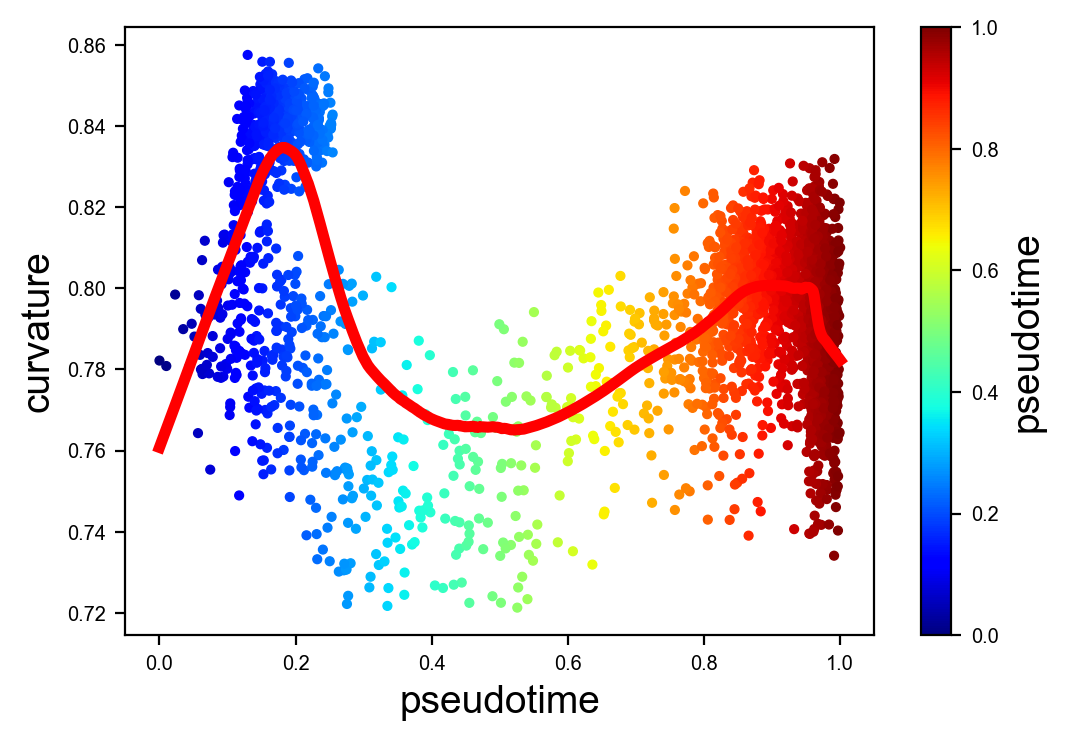

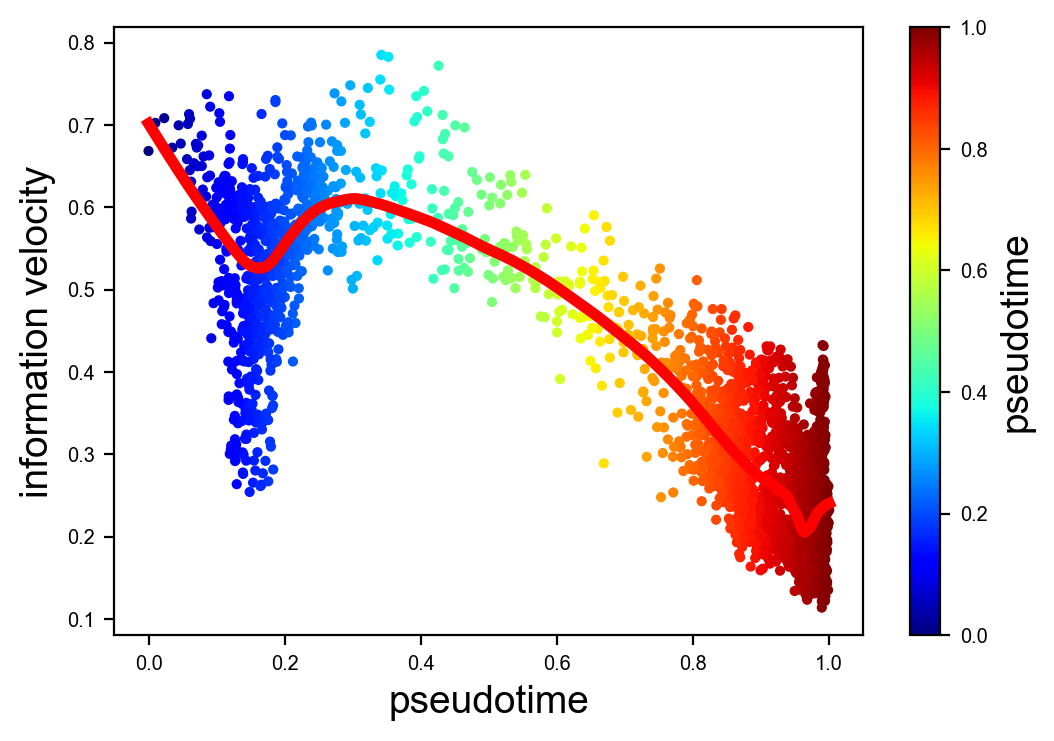

In [558]:
mask,x_ls,y_ls= kde_lowess(cell_vpt,crc_smooth)
plt.scatter(cell_vpt[mask], crc_smooth[mask],s=10,c=cell_vpt[mask],cmap=plt.cm.jet)
plt.plot(x_ls, y_ls, linewidth=4,color='red')
plt.xlabel('pseudotime',fontsize=14)
plt.ylabel('curvature',fontsize=14)
# sns.kdeplot(cell_vpt,cRc_smooth,bw_adjust=0.7)
clb=plt.colorbar()
clb.ax.set_ylabel('pseudotime',fontsize=14)
plt.savefig(result_path+'vpt_cv_kde.png')
plt.show()

mask,x_ls,y_ls= kde_lowess(cell_vpt,zv1_smooth)
plt.scatter(cell_vpt[mask], zv1_smooth[mask],s=10,c=cell_vpt[mask],cmap=plt.cm.jet)
plt.plot(x_ls, y_ls, linewidth=4,color='red')
plt.xlabel('pseudotime',fontsize=14)
plt.ylabel('information velocity',fontsize=14)
# sns.kdeplot(cell_vpt,cRc_smooth,bw_adjust=0.7)
clb=plt.colorbar()
clb.ax.set_ylabel('pseudotime',fontsize=14)
plt.savefig(result_path+'vpt_iv_kde.png')
plt.show()

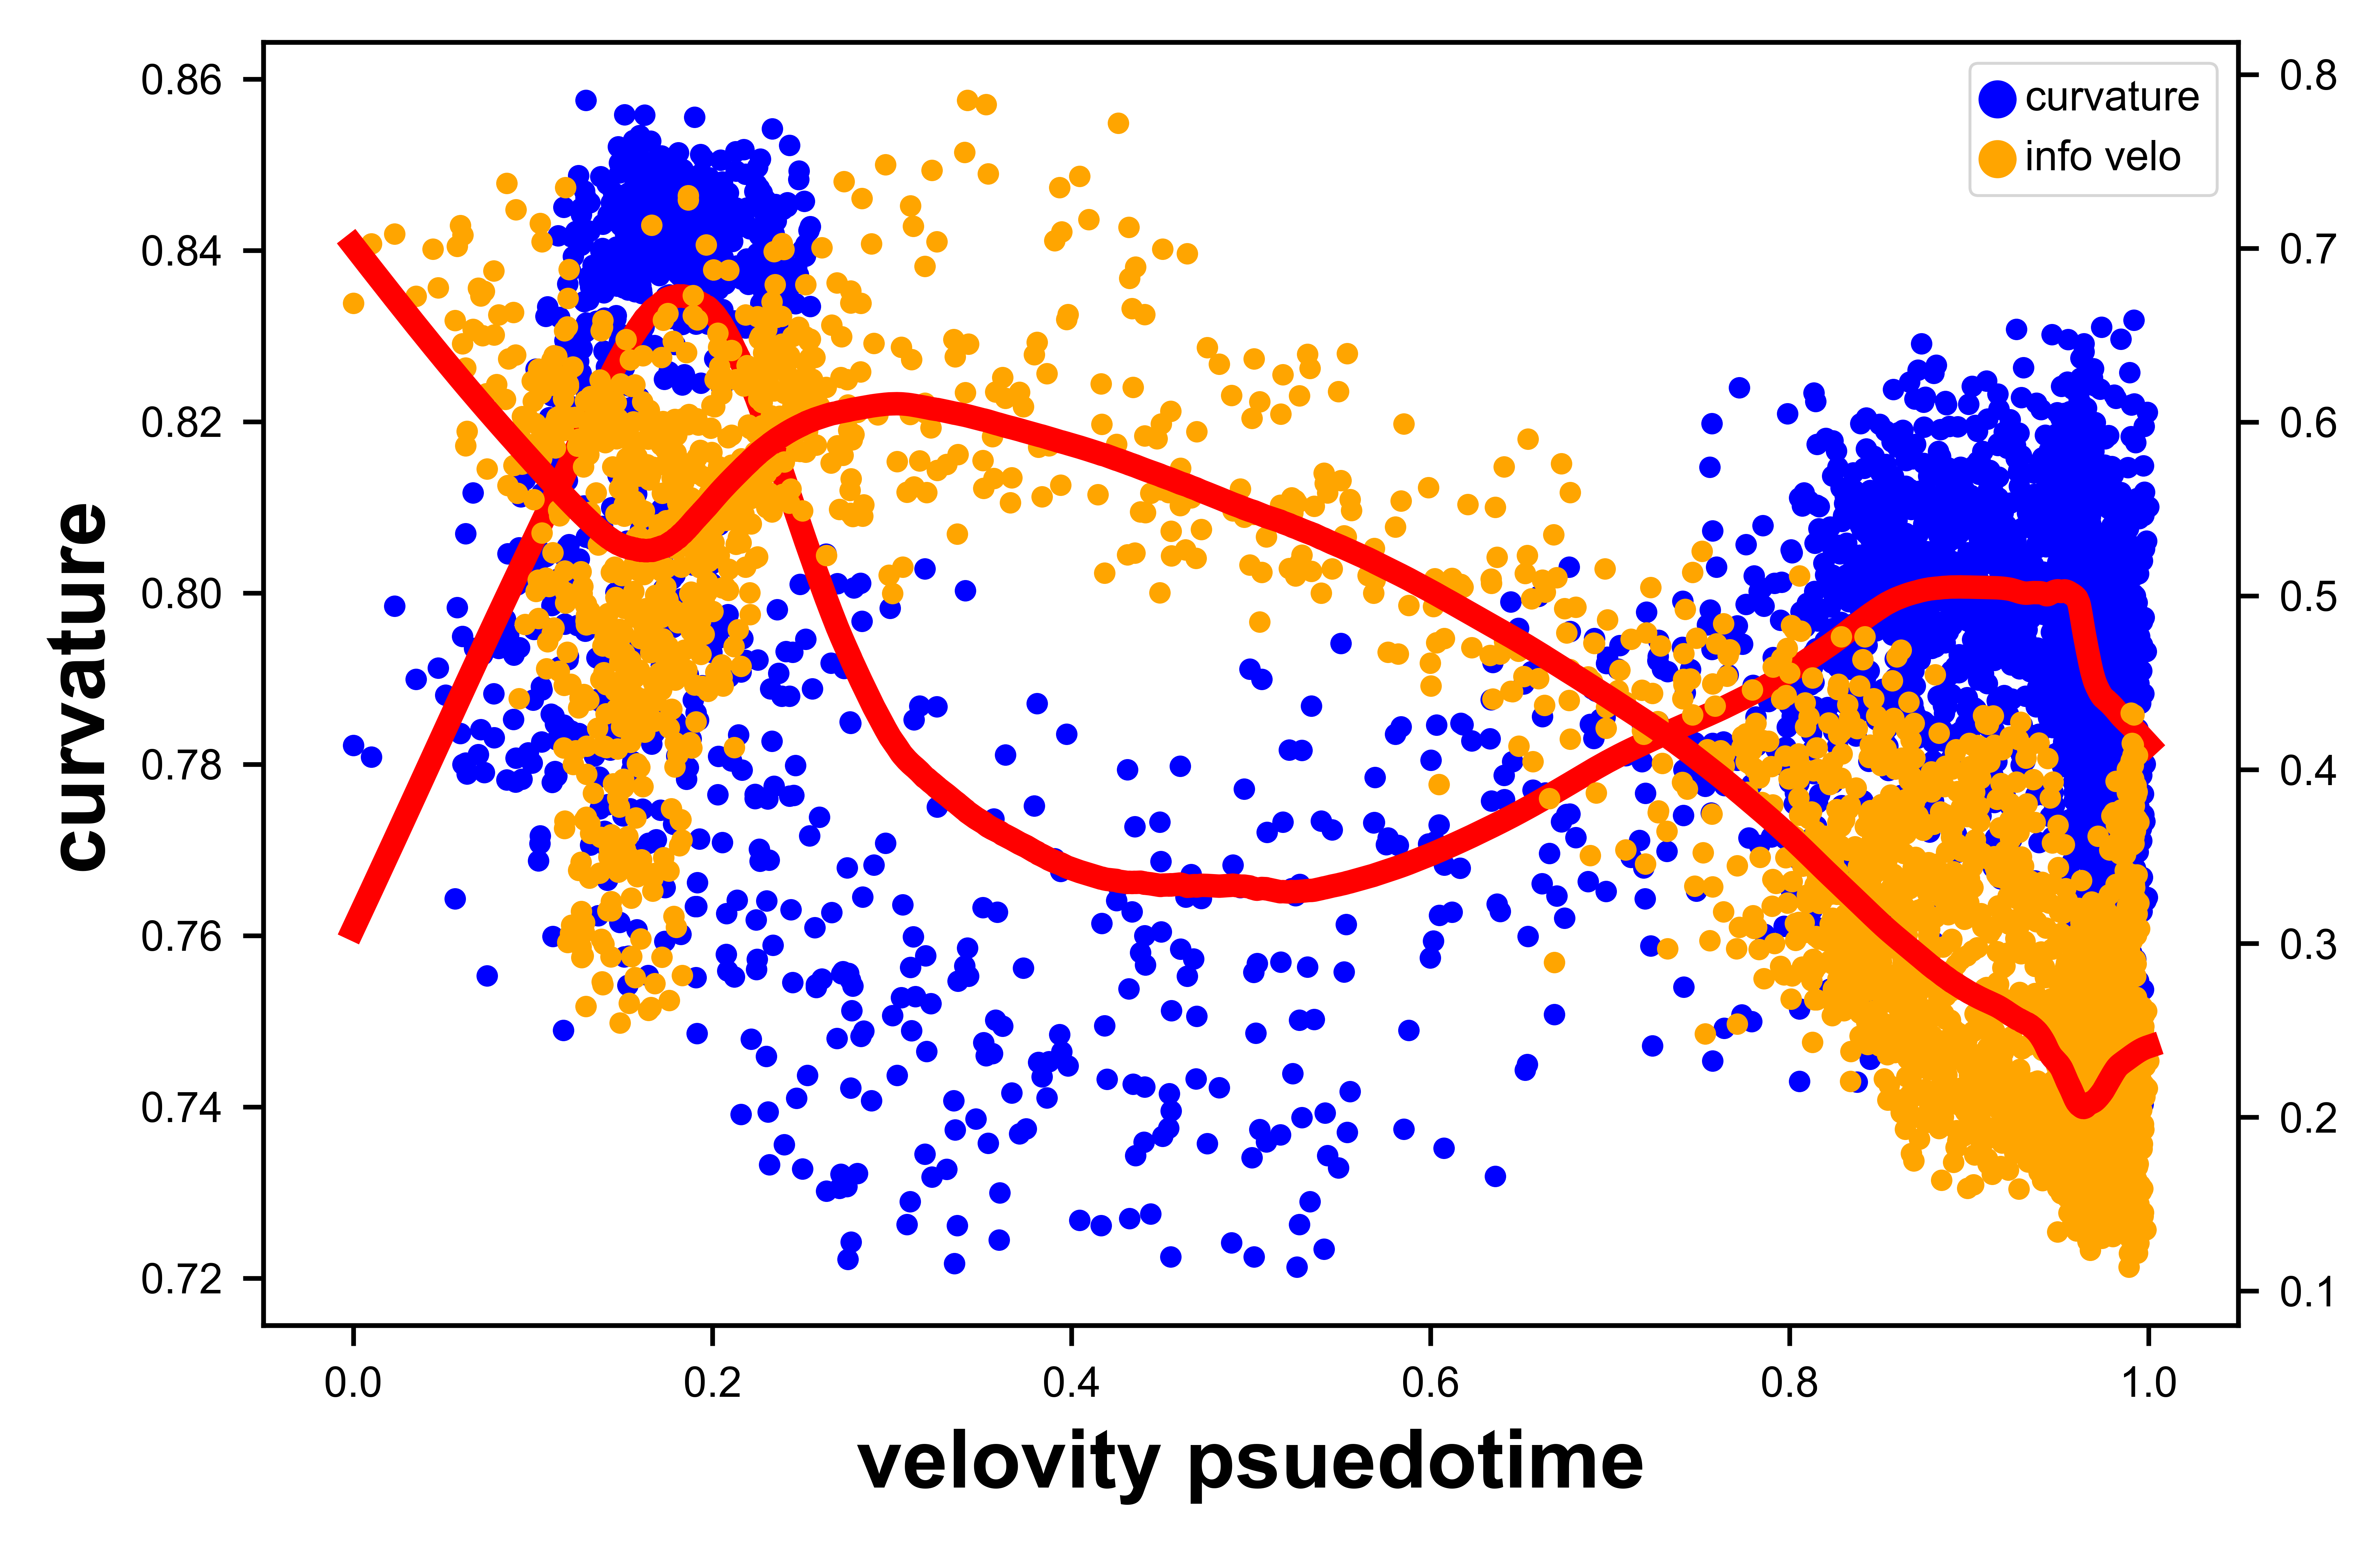

In [559]:
plt.figure(dpi=600)
mask,x_ls,y_ls= kde_lowess(cell_vpt,crc_smooth)
plt.scatter(cell_vpt[mask], crc_smooth[mask],s=10,c='blue',label='curvature')
plt.plot(x_ls, y_ls, linewidth=4,color='red')
plt.xlabel('velovity psuedotime',fontsize=14,weight='bold')
plt.ylabel('curvature',fontsize=14,weight='bold')
plt.twinx()
mask,x_ls,y_ls= kde_lowess(cell_vpt,zv1_smooth)
plt.scatter(cell_vpt[mask], zv1_smooth[mask],s=10,c='orange',label='info velo')
plt.plot(x_ls, y_ls, linewidth=4,color='red')
plt.legend(handles=[ln1,ln2])
plt.savefig(result_path+'cviv_kde.png')
plt.show()

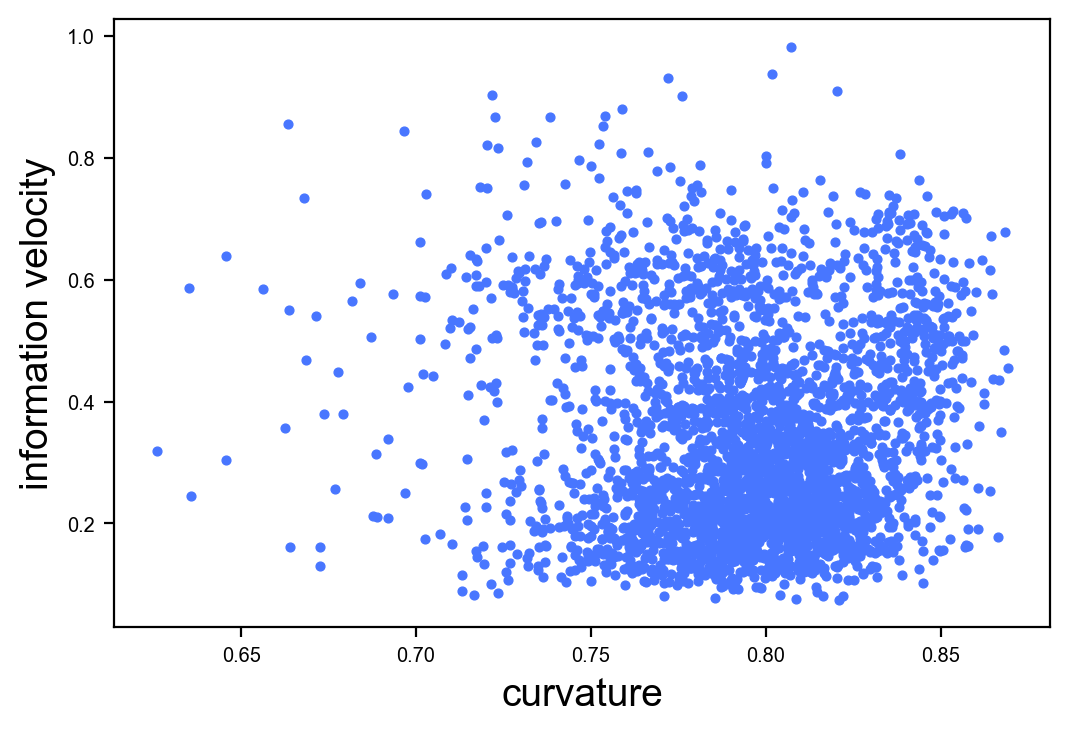

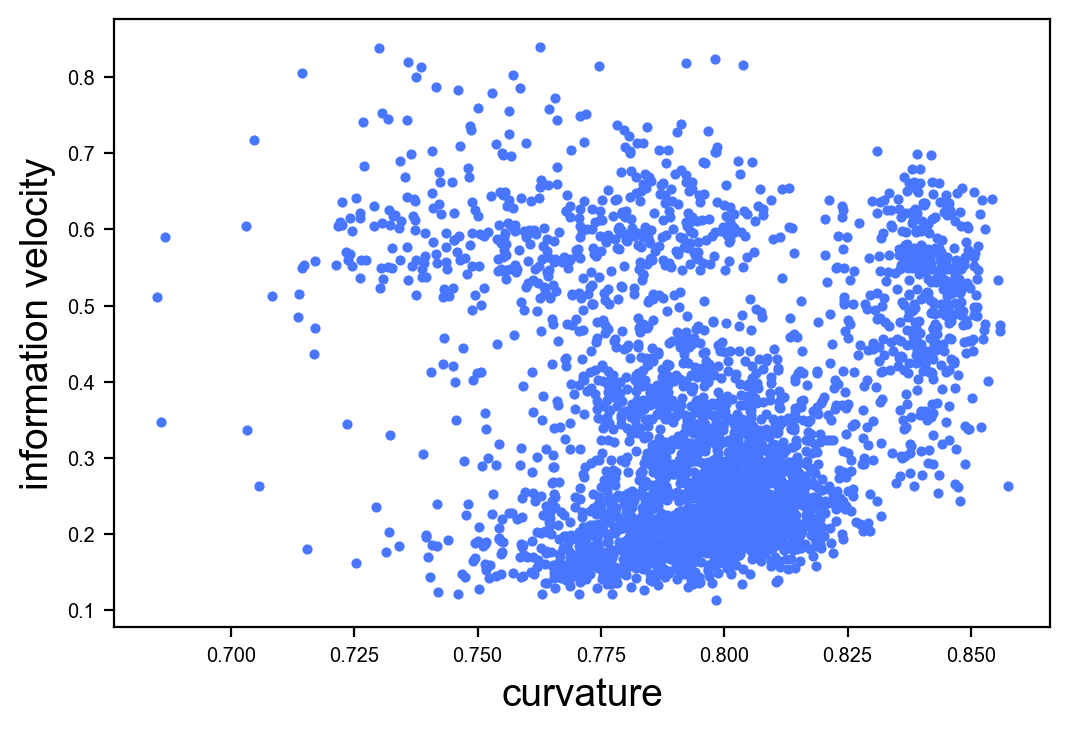

In [560]:
plt.scatter(crc_eu,zv1,s=10)
plt.xlabel('curvature',fontsize=14)
plt.ylabel('information velocity',fontsize=14)
plt.show()

plt.scatter(crc_smooth,zv1_smooth,s=10)
plt.xlabel('curvature',fontsize=14)
plt.ylabel('information velocity',fontsize=14)
plt.show()

In [561]:
# zv0 = np.linalg.norm(velo,axis=1)
# zv0.shape

# ln1 = plt.scatter(cell_vpt,zv1_smooth,c='blue',label='curvature')
# plt.xlabel('velovity psuedotime',fontsize=14,weight='bold')
# plt.ylabel('curvature',fontsize=14,weight='bold')
# plt.twinx()
# ln2 = plt.scatter(cell_vpt,smooth_func(zv0),c='orange',label='info velo')
# plt.ylabel('info velo',fontsize=14,weight='bold')
# plt.legend(handles=[ln1,ln2])
# plt.show()